### Understanding convolutions

http://setosa.io/ev/image-kernels/

In [1]:
from skimage.data import camera, chelsea
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
from torch import nn

def tensor_to_image(tensor):
    image = np.moveaxis(tensor.numpy()[0], 0, 2).astype('uint8')
    return image

(512, 512)

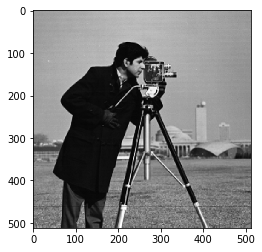

In [2]:
camerman = camera()
plt.imshow(camerman, cmap='gray')

camerman.shape

In [3]:
t_cameraman = torch.from_numpy(camerman).float()
t_cameraman = t_cameraman.unsqueeze(0) # ads dimension at the begining
t_cameraman = t_cameraman.unsqueeze(0)
print(t_cameraman.shape) # torch.Size([1, 1, 512, 512]) (batch size, channels, width, height)


torch.Size([1, 1, 512, 512])


In [4]:
edge_filter  = torch.Tensor([[[[-1,-1,-1],
                               [-1, 8, -1], 
                               [-1,-1, -1]]
                             ]])


output = F.conv2d(t_cameraman, edge_filter, padding=1)

edge_filter.shape

torch.Size([1, 1, 3, 3])

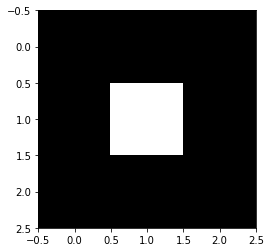

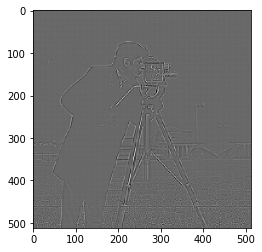

In [5]:
plt.figure()
plt.imshow(edge_filter.numpy()[0][0], cmap='gray')
plt.figure()
plt.imshow(output[0][0],cmap='gray')

In [6]:
left_sobel  = torch.Tensor([[[[1,0,-1],
                              [1,0,-1], 
                              [1,0,-1]]]]) 

output = F.relu(F.conv2d(t_cameraman, left_sobel, padding=1))


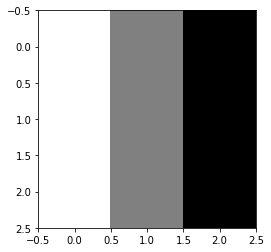

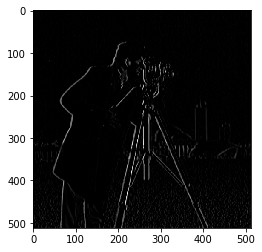

In [7]:
plt.figure()
plt.imshow(left_sobel.numpy()[0][0], cmap='gray')
plt.figure()
plt.imshow(output[0][0].numpy(),cmap='gray')

# RGB convolutions
![](rgb.gif)

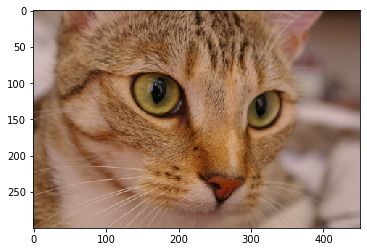

In [8]:
ch = chelsea()
plt.imshow(ch)

In [9]:
# Pytorch expects channels first 

t_ch = torch.from_numpy(ch).float()
print(t_ch.shape)
t_ch = t_ch.unsqueeze(0)
t_ch = t_ch.permute([0,3,1,2]) # in numpy swappping from channels last to channels first can be done with moveaxis
tch = t_ch / 255
print(t_ch.shape)


torch.Size([300, 451, 3])
torch.Size([1, 3, 300, 451])


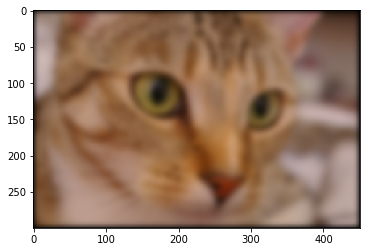

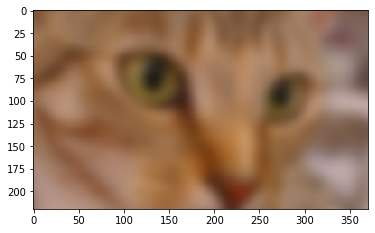

In [10]:
# since this is a color image we need to have a filter for each color-chanel thus we repeat the kernel 3 times

blur  = torch.Tensor([[[[1/16, 1/8,1/16],
                              [1/8, 1/4, 1/8], 
                              [1/16, 1/8,1/16]]]]) 
# left_sobel = left_sobel.repeat((1, 3, 1, 1))

# blur = torch.ones((1,1,5,5)) / 16

r = t_ch[:, 0:1, :, :]
g = t_ch[:, 1:2, :, :]
b = t_ch[:, 2:3, :, :]


for i in range(40):
    r = F.conv2d(r, blur, padding=1)
    g = F.conv2d(g, blur, padding=1)
    b = F.conv2d(b, blur, padding=1)

image = torch.cat([r, g, b], dim=1)
image = np.moveaxis(image.numpy()[0], 0, 2).astype('uint8')

plt.figure()
plt.imshow(image)

for i in range(40):
    r = F.conv2d(r, blur, padding=0)
    g = F.conv2d(g, blur, padding=0)
    b = F.conv2d(b, blur, padding=0)

image = torch.cat([r, g, b], dim=1)
image = np.moveaxis(image.numpy()[0], 0, 2).astype('uint8')

plt.figure()
plt.imshow(image)

In [11]:
blur

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])

In [12]:
c2 = nn.Conv2d(3, 10, 5,padding=2)
# c3 = nn.Conv2d(10, 10, 3, padding=1)

# im = (c2(tch).detach().numpy() * 255).astype('uint8')
# plt.imshow(np.moveaxis(im[0], 0, 2))
c2.weight.shape

torch.Size([10, 3, 5, 5])

# Pooling 

avgpool
maxpool


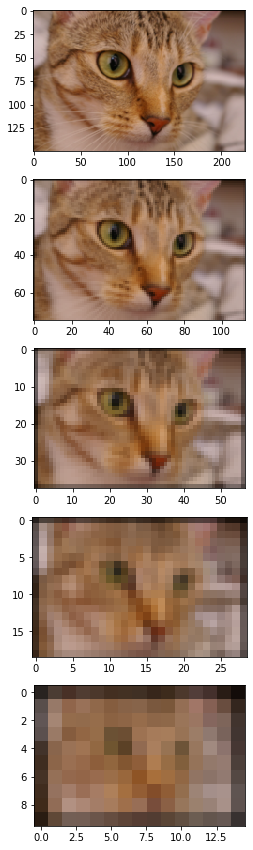

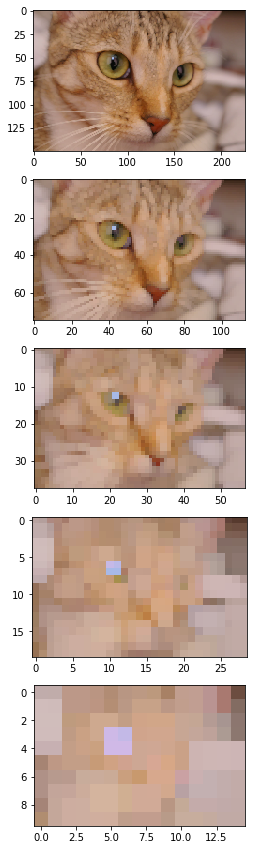

In [13]:
image = t_ch
f = plt.figure(figsize=(15,15))
print('avgpool')
for i in range(5):
    image = nn.AvgPool2d(3, stride=2, padding=1)(image)
    plt.subplot(5,1,i+1)
    plt.imshow(tensor_to_image(image))
    

print("maxpool")    
image = t_ch
f = plt.figure(figsize=(15,15))
for i in range(5):
    image = nn.MaxPool2d(3, stride=2, padding=1)(image)
    plt.subplot(5,1,i+1)
    plt.imshow(tensor_to_image(image))

    

# Adaptive Pooling

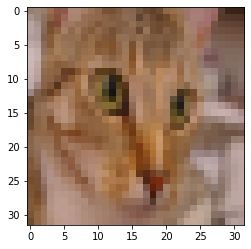

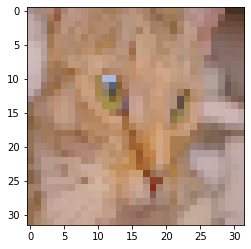

In [14]:
adapt = nn.AdaptiveAvgPool2d((32, 32))
image = adapt(t_ch)
plt.figure(); plt.imshow(tensor_to_image(image))


adapt = nn.AdaptiveMaxPool2d((32, 32))
image = adapt(t_ch)
plt.figure(); plt.imshow(tensor_to_image(image))

# 1x1 Convolutions

In [15]:
conv11 = nn.Conv2d(32, 1, 1, 1)
X = torch.rand(1, 32, 32, 32)
conv11(X)

tensor([[[[-0.0688, -0.0024, -0.0967,  ..., -0.3674, -0.2837, -0.0815],
          [-0.2239, -0.1966, -0.2478,  ..., -0.6557, -0.3257, -0.2439],
          [-0.1520, -0.4394, -0.0325,  ..., -0.1135, -0.4122, -0.0330],
          ...,
          [-0.3160, -0.4266, -0.2854,  ..., -0.1579, -0.3225, -0.1507],
          [-0.4132, -0.2110, -0.1761,  ..., -0.0097, -0.2465, -0.2402],
          [ 0.0178,  0.0594,  0.1923,  ...,  0.2307, -0.1473, -0.1821]]]],
       grad_fn=<MkldnnConvolutionBackward>)

# Tips and tricks

- pytorch comes with handy utility functions like ones_like, ones, zeroes_like, etc. They come handy quite often

# Exercises

1. Create different sizes of bluring kernels. For instance (3x3, 7x7, 9x9) apply them on the cameraman picture  and compare the results side by side.

2. Explore Adaptive(AVG/MAX)Pooling try using it analogous to how we did for max and avg pool. When this might come in handy?

3. Search up the term "receptive field" in the context of deep learning and convolutional neural networks